# FlattenLabelDist tutorial
In this tutorial, you will see a multi-label dataset get extended with samples from it, resulting in its distribution of labels becoming more uniform (**A minimal example**). 
You will also read about which `score` to choose for extending the samples (**Which `score` to choose**. TL;DR: Use the default). 
Finally, the algorithm is described in detail under **Description of the algorithm**.

## A minimal example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

# Import the FlattenLabelDist class from flattenlabeldist.py.
from flattenlabeldist import FlattenLabelDist # NOTE: The module 'tqdm' should be installed.

In [2]:
# rcParams updates must be placed in a different cell than importing matplotlib.
# (see https://github.com/ipython/ipython/issues/11098)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,8)

### Create a toy dataset
*NOTE:* Understanding what is going on in this cell is not necessary. 

It may be worth noting, however, that the so-called label matrix (``labelMatrix`` in the script below, which is passed to ``FlattenLabelDist.__init__``) must be an $N\times K$ (where $N$ is the number of samples in the dataset and $K$ is the number of different possible labels) matrix $\mathbf{Y}$ with $\mathbf{Y}_{ij}=1$ if sample $i$ has label $j$ and $\mathbf{Y}_{ij}=0$ otherwise.

In [3]:
# Create a label matrix with N samples and K different possible labels from a power distribution.
# A power distribution is chosen as it can be very uneven (and thus challenging) and often appears
# in real-world data.

N = 10**4 # The number of samples in our toy dataset.
K = 100 # The number of different labels in our toy dataset.

# Create label distribution.
initLabelDist_not_normed = (np.random.power(0.25,K)*N).astype(int)

# Ensure that there is at least one sample with any label.
initLabelDist_not_normed[initLabelDist_not_normed < 1] = 1

# Create corresponding label matrix.
labelMatrix = np.zeros((N,K))
for label in range(K):
    labelCount = initLabelDist_not_normed[label]
    affectedIndices = np.random.permutation(N)[:labelCount]
    labelMatrix[affectedIndices,label] = 1 

### Carry out the extensions

In [4]:
N_ext = 10*N # The number of wanted extensions.
FLD = FlattenLabelDist(labelMatrix, N_ext) # Create class instance. This uses the 'entropy' score.
extensionIDs,extLabelDist = FLD.run() # Carry out the extensions. This creates a progressbar.

100%|████████████████████████████████| 100000/100000 [00:39<00:00, 2609.78it/s]

### Plot the result sorted according to the initial distribution

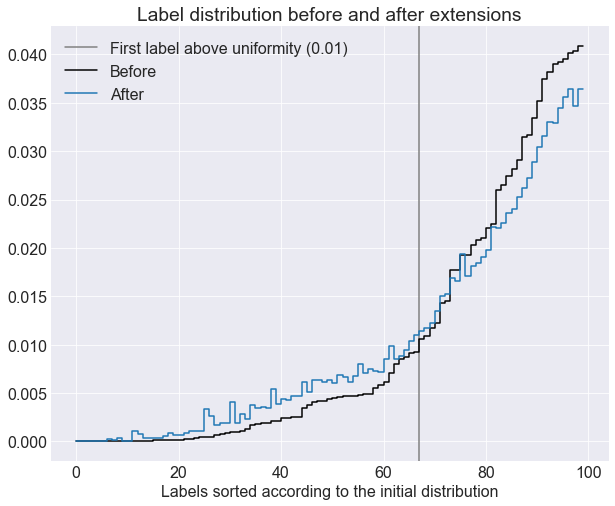

In [5]:
# Normalize distributions so they can be plotted together.
initLabelDist = initLabelDist_not_normed/np.sum(initLabelDist_not_normed)
extLabelDist /= np.sum(extLabelDist) 

sorted_indices = np.argsort(initLabelDist)

# Find first label over 1/K in the sorted initial distribution of labels.
first_label_over_uniformity = next(label for label,distValue in enumerate(initLabelDist[sorted_indices]) if distValue > 1/K)-1

fig,ax = plt.subplots()
ax.axvline(x=first_label_over_uniformity, color='gray', label='First label above uniformity ({})'.format(1/K))
ax.plot(np.arange(K), initLabelDist[sorted_indices], color='k', ls='steps', label='Before')
ax.plot(np.arange(K), extLabelDist[sorted_indices], ls='steps', label='After')
ax.set_title('Label distribution before and after extensions')
ax.set_xlabel('Labels sorted according to the initial distribution')
ax.legend(loc='best')
plt.show()

We see that the the normalized frequency of labels laying below uniformity $(1/K)$ tend to have increased, while those above tend to have decreased.

## Which `score` should you choose?
You can choose between three different `score` functions: `entropy`, `MAE` (mean absolute error), and `MSE` (mean squared error). 

The `score` is a function that takes a distribution of labels and returns a score according to how close to a uniform distribution it deems the distribution to be. This score is used to determine if a sample should be extended or not (it will be extended if the extension results in the label distribution having a better score than before the extension).

The three scores `entropy`, `MAE`, and `MSE` all prioritize different things when it comes to making a distribution of labels more uniform: `MSE` is good at squashing very frequent labels (but not so good at anything else), `MAE` is good at evening out labels that lie in the neighbourhood of uniformity $(1/K)$, and `entropy` is good at boosting rare labels and is generally well-rounded. Since the qualities of the `entropy` score is usually what you want when trying to make a dataset more level, `entropy` is the default option. `MAE` should not be underestimated though, so you can experiment with it if you want, but it can get slow when the number of extensions becomes large $(N_{\mathrm{ext}}\gtrsim 10N)$, especially for large datasets $(N\gtrsim 10^6).$

Below you can see the averaged results of extending 100 different dataset generated as in the preceding section using all three scores, where you can see for yourself what the strengths and weaknesses of the scores are. This takes some time to run, so if you're in a hurry, just look at the plots.

**TL;DR**: Use the default `score=entropy` if you are mainly after boosting the frequency of rare labels. Try out `MAE` if your dataset and the number of wanted extensions aren't too large (or if you have the time) and you want to prioritize evening out all labels equally. If you mainly want to squash high frequency labels, use `MSE`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
from tqdm import tqdm

from flattenlabeldist import FlattenLabelDist

In [2]:
# rcParams updates must be placed in a different cell than importing matplotlib.
# (see https://github.com/ipython/ipython/issues/11098)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,8)

### Create datasets and run extensions for each

In [3]:
N = 10**4 # The number of samples in our toy datasets.
K = 100 # The number of different labels in our toy datasets.
N_ext = 10*N # The number of wanted extensions.
nRuns = 100 # The number of runs to average over.
scores = ['entropy','MAE','MSE'] # The scores we would like to compare.
initLabelDist_all = [] # For collecting all created initial label distributions.
extLabelDist_all = [ [[]]*len(scores) for _ in range(nRuns) ] # For collecting 
                    # all extended label distributions (all runs, all scores). 
                    # Will have shape (nRuns,len(scores),K).
successRatios_all = [ [[]]*len(scores) for _ in range(nRuns) ] # For collecting 
                    # successRatios for all extended label distributions (all
                    # runs, all scores). Will have shape (nRuns,len(scores),nLogs,2).
percentPosImp_all = [ [[]]*len(scores) for _ in range(nRuns) ] # For collecting 
                    # percentPosImp for all extended label distributions (all
                    # runs, all scores). Will have shape (nRuns,len(scores),nLogs,2).

for run in tqdm(range(nRuns)):
    # Create dataset.
    initLabelDist_not_normed = (np.random.power(0.25,K)*N).astype(int)
    initLabelDist_not_normed[initLabelDist_not_normed < 1] = 1
    labelMatrix = np.zeros((N,K))
    for label in range(K):
        labelCount = initLabelDist_not_normed[label]
        affectedIndices = np.random.permutation(N)[:labelCount]
        labelMatrix[affectedIndices,label] = 1 
        
    # Sort and collect the initial label distribution.
    sorted_indices = np.argsort(initLabelDist_not_normed)
    initLabelDist_not_normed_sorted = initLabelDist_not_normed[sorted_indices]
    initLabelDist_all.append(initLabelDist_not_normed_sorted)
    
    # Carry out extensions for all three scores and collect them. 
    # The distributions are also sorted according to the initial distribution.
    for nScore,score in enumerate(scores):
        FLD = FlattenLabelDist(labelMatrix, N_ext, score=score, verbose=0)
        extLabelDist_all[run][nScore] = FLD.run()[1][sorted_indices]
        successRatios_all[run][nScore] = FLD.successRatios
        percentPosImp_all[run][nScore] = FLD.percentPosImp

100%|██████████████████████████████████████| 100/100 [2:07:28<00:00, 76.49s/it]


### Plot the results

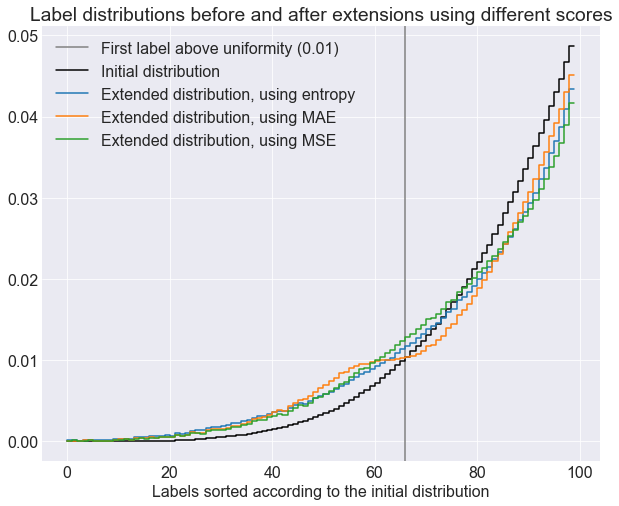

In [4]:
# Average.
initLabelDist_mean = np.mean(initLabelDist_all, axis=0)
extLabelDist_means = np.mean(extLabelDist_all, axis=0)

# Normalize.
initLabelDist_mean /= np.sum(initLabelDist_mean)
for i in range(len(scores)):
    extLabelDist_means[i] = extLabelDist_means[i]/np.sum(extLabelDist_means[i])
    
# Find first label over 1/K in the average sorted initial distribution of labels.
first_label_over_uniformity = next(label for label,distValue in enumerate(initLabelDist_mean) if distValue > 1/K)-1

# Plot the results.
fig,ax = plt.subplots()
ax.axvline(x=first_label_over_uniformity, color='gray', label='First label above uniformity ({})'.format(1/K))
ax.plot(np.arange(K), initLabelDist_mean, color='k', ls='steps', label='Initial distribution')
for numScore,score in enumerate(scores):
    ax.plot(np.arange(K), extLabelDist_means[numScore], ls='steps', label='Extended distribution, using {}'.format(score))
ax.set_title('Label distributions before and after extensions using different scores')
ax.set_xlabel('Labels sorted according to the initial distribution')
ax.legend(loc='best')
plt.show()

It is a bit hard to see what is going on here, so let's plot the residuals (the extended minus the initial distribution) instead.

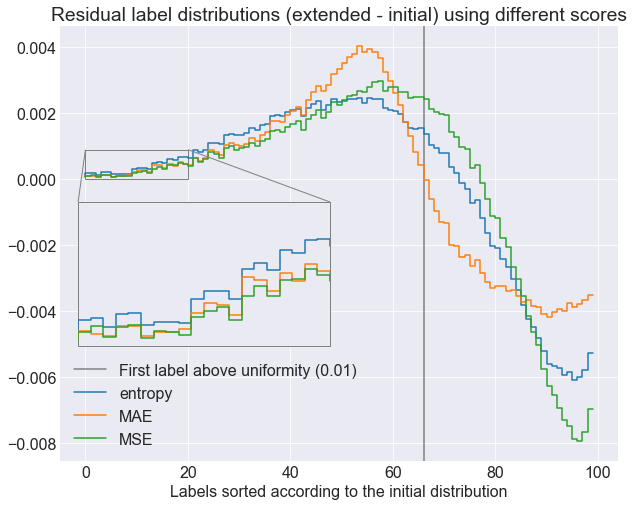

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig,ax = plt.subplots()
ax_sub = fig.add_axes([0.15,0.325,0.35,0.25]) 
ax.axvline(x=first_label_over_uniformity, color='gray', label='First label above uniformity ({:.2f})'.format(1/K))
for numScore,score in enumerate(scores):
    ax.plot(np.arange(K), extLabelDist_means[numScore]-initLabelDist_mean, ls='steps', label=score)
    ax_sub.plot(np.arange(K), extLabelDist_means[numScore]-initLabelDist_mean, ls='steps')
ax_sub.set_xticks([])
ax_sub.set_yticks([])
ax_sub.set_xlim(0,20)
ax_sub.set_ylim(0,np.max(extLabelDist_means[0][:int(ax_sub.get_xlim()[1])])*1.2)
mark_inset(ax, ax_sub, loc1=2, loc2=1, fc='none', ec='0.5')
autoAxis = ax_sub.axis()
rec = plt.Rectangle((autoAxis[0],autoAxis[2]),(autoAxis[1]-autoAxis[0]),(autoAxis[3]-autoAxis[2]), fill=False, color='gray')
rec = ax_sub.add_patch(rec)
rec.set_clip_on(False)
ax.set_title('Residual label distributions (extended - initial) using different scores')
ax.set_xlabel('Labels sorted according to the initial distribution')
ax.legend(loc='lower left')
plt.show()

### Efficiency and quality of extensions using different scores

We can also take a look at the average efficiency and quality of the extensions for each score. 

Here, efficiency is measured by the *success ratio* (returned by the `successRatios` attribute), defined as the number of accepted per attempted extensions. The success ratio is a measure of how little time is wasted trying to extend samples which do not contribute to make the distribution of labels more uniform, and is inversely proportional to the total runtime. The solid lines in the figure below show the mean success ratio when choosing to extend $N_{\mathrm{ext}}$ samples of the original dataset with size $N$.

We see that `entropy` has an early edge, but that `MSE` scales the best, while `MAE` scales the worst.

In order to measure the quality of the extensions made using a score, we can introduce the *linear improvement*, which measures how much closer/further away the normalized frequency of a label has moved toward/from uniformity after all extensions have been made. Formally, the linear improvement is given by
\begin{equation}\label{eq:improvement}
    J_j = \left\{\begin{array}{ll}
        s_j \left|p_j^{\mathrm{init}}-p_j^{\mathrm{ext}}\right|-\left(\frac{1}{K}-\min\left(p_j^{\mathrm{init}},p_j^{\mathrm{ext}}\right)\right), & \text{for }\;
        \begin{array}{l}
            p_j^{\mathrm{init}}\!<1/K\!<p_j^{\mathrm{ext}}\\
            p_j^{\mathrm{ext}}\!<1/K\!<p_j^{\mathrm{init}} 
        \end{array}\\
        s_j \left|p_j^{\mathrm{init}}-p_j^{\mathrm{ext}}\right|, & \text{otherwise}
        \end{array}\right.,
\end{equation}
where $p_j^{\mathrm{init}}$ is the normalized frequency of the $j$th label for the inital label distribution, $p_j^{\mathrm{ext}}$ is the same but for the extended label distribution (for the chosen score), and where $s_j=\mathrm{sign}\left(\left(\frac{1}{K}-p_j^{\mathrm{init}}\right)\times\left(p_j^{\mathrm{ext}}-p_j^{\mathrm{init}}\right)\right)$ is positive if $p_j^{\mathrm{init}}$ has moved towards $1/K$, and negative if it has moved away from it. If $p_j^{\mathrm{ext}}$ overshoots the target of $1/K,$ as in the first case of the above equation, the overshot distance is subtracted from $J_j.$

The percent of labels for which $J_j>0$ is captured by the attribute `percentPosImp` and is also plotted in the figure below.

We see that `entropy` beats the two others, with `MAE` following, and that `MSE` performs particularly poorly in this regard, which happens exactly because it focuses its efforts on squashing frequent labels, as mentioned above.

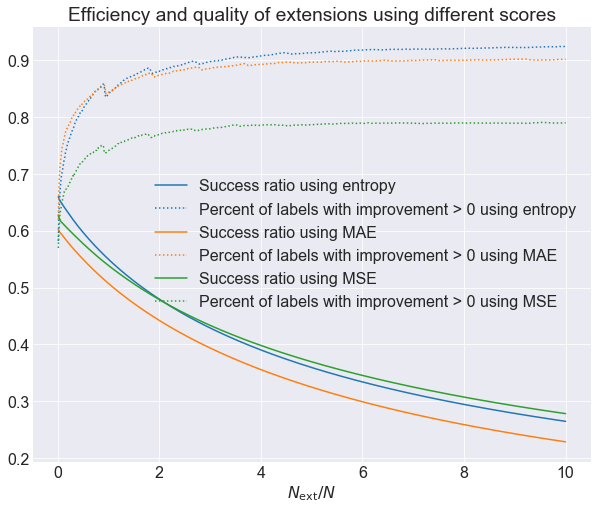

In [6]:
# Average.
successRatios_means = np.mean(successRatios_all, axis=0)
percentPosImp_means = np.mean(percentPosImp_all, axis=0)

# Plot the results.
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig,ax = plt.subplots()
for i,(successRatios,percentPosImp,score) in enumerate(zip(successRatios_means,percentPosImp_means,scores)):
    succesRatioRunningMean = [np.mean(successRatios[:j,1]) for j in range(1,successRatios.shape[0]+1)]
    ax.plot(successRatios[:,0]/N, np.array(succesRatioRunningMean), color=colors[i], label='Success ratio using {}'.format(score))
    ax.plot(percentPosImp[:,0]/N, percentPosImp[:,1], color=colors[i], ls=':', label='Percent of labels with improvement > 0 using {}'.format(score))
ax.set_xlabel(r'$N_{\mathrm{ext}}/N$')
ax.set_title('Efficiency and quality of extensions using different scores')
ax.legend(loc='best')
plt.show()

## Description of the algorithm

Assume that our initial multi-label dataset consists of $N$ samples labelled with a total of $K$ different labels being $\{1,2,\dots,K\}.$ To keep track of the labels of all samples, we define the $N\times K$ label matrix $\mathbf{Y}$ with $\mathbf{Y}_{ij}=1$ if sample $i$ has label $j$ and $\mathbf{Y}_{ij}=0$ otherwise.

#### How to decide if a sample should be extended or not
In order to determine which samples should be extended so as to make our distribution of labels more uniform, we can make use of a score measuring uniformity. Three such scores are the mean squared error, $\mathrm{MSE}=\frac{1}{K}\sum_{j=1}^K \left(p_j-\frac{1}{K}\right)^2$, the mean absolute error, $\mathrm{MAE}=\frac{1}{K}\sum_{j=1}^K \left|p_j-\frac{1}{K}\right|,$ and the entropy, $S = -\sum_{j=1}^K p_j \log p_j,$ for some normalized distribution of labels $P=\{p_j\}_{j=1}^K$ (given by $p_j=\sum_{i=1}^{N}\mathbf{Y}_{ij}\big/\sum_{i,j=1}^{N,K} \mathbf{Y}_{ij}$ for the initial dataset).
In order to more easily compare the three scores, the entropy can be transformed into a lower-is-better version, $\tilde{S}=1-S/\log K,$ which is what is used in the above implementation. 

The basic idea is now to try extending some sample, such that the label matrix $\mathbf{Y}$ gets one more row, and accepting this extension only if the chosen score of the resulting distribution of labels decreases. But which samples should we try extending?

#### Importance sampling
In order to efficiently find samples which will lead to a more uniform distribution, we can use a modified version of inverse transform sampling. If we let $f(j)=p_j$ represent our normalized label distribution and $F(j)=\sum_{i=1}^j f(i)$ its corresponding cumulative distribution, standard inverse transform sampling would imply drawing $u$, a random number uniform on the unit interval, to get a label $F^{-1}(u)=j.$ However, this makes frequent labels more likely to be sampled, which is the opposite of what we want. In order for seldom labels to be more likely to be sampled, we can instead create the distribution 
\begin{equation}
    \tilde{f}(j)=\frac{\hat{p}-p_j}{\hat{p}K-1},
\end{equation}
where $\hat{p}=\mathrm{max}(P)+\mathrm{min}(P)$, which maps a given $p_j$ to its reflection about the midpoint between $\mathrm{max}(P)$ and $\mathrm{min}(P)$. If we denote its corresponding cumulative distribution $\tilde{F}(j),$ we should then try to extend samples with label $\tilde{F}^{-1}(u)=j,$ to see if this causes the chosen score to decrease. 

#### Avoiding being stuck in local minima
Having chosen a label, we now go through (the original) samples with this label, extending the first that causes our score to decrease. To avoid oversampling the first samples in this list, while undersampling the last, we should first shuffle our list of sample indices. A simple way of generating a shuffled list would be to draw a random permutation of the range of numbers up to the number of samples with the label in question. Unfortunately, however, this scales poorly with the number of samples. 

In the present algorithm, a small but effective subset of all the permutations are instead used: The list of sample indices are first translated by a random number between zero and one short of the total number of samples with the label in question. If, for instance, our list of sample indices were $(4,5,10,21)$, we would draw a random number between zero and three. If we, say, drew $1$, our list would be $(21,4,5,10)$. After this, with probability $1/2$, the list is flipped, in our case giving the final list of $(10,5,4,21)$. 

This procedure ensures that every sample is equally likely to be at any position in the list, and that the probability of $a$ being before $b$ in the list equals that of $b$ being before $a$, for any two samples $a,b$ in the list. Testing seems to suggest this being a sufficient amount of shuffling, while scaling far better than drawing any random permutation.

#### Putting it all together
We can now formulate an entire algorithm for extending samples with rare labels: Given a label matrix and a score, draw a label $\tilde{F}^{-1}(u)=j.$ Shuffle all samples with this label and go through them one by one. For each, extend the label matrix with this sample. If the chosen score for the resulting extended label matrix is lower than before the extension, the extension is accepted and a new label is drawn. The algorithm halts if the number of wanted extensions is reached, or if the number of consecutive times a label that did not result in an extension of any sample with that label is chosen becomes too large.